# Quality assessment of glacier mass change data from satellite and in-situ observations: resolution, coverage and uncertainty for glaciological, climatological and hydrlogical monitoring

- Data stream: satellite (observations), in-situ (observations)
- Quality area: completeness, resolution, accuracy and precision (uncertainty)
- Application area: glaciological, climatological and/or hydrlogical applications, monitoring and models

Production date: 17-07-2024

Produced by: Yoni Verhaegen and Philippe Huybrechts (Vrije Universiteit Brussel)

## 🌍 Use case: Quantifying the link between glacier melt and glacier-related contributions to global sea level rise in the context of Earth System modeling and climate change monitoring

## ❓ Quality assessment question
* **"Is the dataset sufficiently accurate, precise and consistent in terms of temporal and geographical coverage to effectively monitor and evaluate global (cumulative) glacier mass changes over time, including their associated impacts on global sea level rise?"**

Glaciers are a major contributor to current global sea-level rise, a resource of fresh water, a potential threat of natural hazards, and an important factor for hydropower production and runoff, as well as for recreation and tourism. A proper assessment of glacier mass changes due to warming climatic conditions therefore plays a crucial role in dealing with these issues. In that regard, the 'Glacier mass change gridded data from 1976 to present derived from the Fluctuations of Glaciers Database' dataset provides key information with respect to glacier mass change data at various spatial and temporal scales. The dataset on the Climate Data Store (CDS) is based on the Fluctuations of Glaciers (FoG) dataset (here we use version 2023-09), which are currently the most complete available datasets in terms of glacier mass changes, with a nearly global coverage (Zemp et al., 2019). It is a compilation of research data from in-situ, air and spaceborne methods (e.g. WGMS, 2022; Berthier et al., 2023), which have been put together and organized into one single gridded dataset. However, several known issues still persist in the dataset of which the user should take note before using the product. In that regard, this notebook investigates how well the dataset can be used to quantify the link between glacier melt and glacier-related sea level contributions. More specifically, the notebook evaluates whether the dataset is of sufficient maturity and quality for that purpose in terms of its precision, accuracy and consistency with respect to the temporal and geographical coverage (i.e. data completeness).

## 📢 Quality assessment statement

- The glaciers mass change dataset on the Climate Data Store (CDS) is currently the most complete dataset of glacier mass change data in terms of its spatial coverage. It is generally considered the main reference dataset to determine the glaciers mass change across the globe.
- A quantitative pixel-by-pixel error estimate is available for the dataset in the form of precision errors (reported as 1.96 times the standard deviation). When evaluating these data, it can be seen that a decreasing trend with respect to mean overall glacier mass change uncertainties over time is present. During the earlier years of the dataset, the overall average  uncertainty values (considered as an arithmetic mean over the entire globe for a certain year) do not meet the minimum threshold proposed by the GCOS (GCOS, 2022). During the more recent years (after 2000 CE), the threshold is, albeit narrowly, met. Nevertheless, there is a high spatial heterogeneity of these uncertainty values. Especially peripheral glaciers of the Greenland and Antarctic ice sheets exhibit clearly too high error values. For error propagation, it is, however, not stated whether errors are spatially or temporally correlated.
- The data can be considered highly mature and complete in terms of its spatial and temporal coverage. Global glacier areas and their trend over time, that are used as input data for the glacier mass change calculations, agree well with values from other reference datasets and numbers found in the literature. There are no data gaps in space, nor in time and the dataset thus takes into account realistic glacier area changes to derive glacier mass changes over time. The glacier area change is, however, parameterized as a regional linear decrease over time and hence not given from direct observations.
- Given the above, it can be stated that the dataset is found to be highly suitable to monitor and derive global (cumulative) mass changes over time and to, for example, assess the corresponding impact on global sea level changes in the context of Earth System modeling and climate change monitoring. The dataset has sufficient quality in terms of its precision error (which is especially true during the more recent years and outside of the peripheral areas of Antarctica and Greenland) and its consistency with respect to spatial (i.e. global) and temporal (i.e. since 1975-76) coverage, as there are no data gaps. Nevertheless, it must be stressed that not all pixels meet the minimum GCOS threshold in terms of precision and thus require extra care. Moreover, in order to calculate effective global sea level changes (i.e. to exclude glacier ice that does not contribute to global sea level changes), additional external information is required from the user.
- When using the glacier mass change dataset that is available on the CDS, users should be aware of other typical problems with the dataset. One of such problems is the fact that data can not be consulted at the individual glacier-scale and that it is hence impossible to determine the number of sampled glaciers in a particular year for which mass or elevation changes and their error estimates are available. This lacking info can impact the quality and suitability of the data for similar glaciological, hydrological, and climatological applications. Data were furthermore measured and generated by different institutes/research groups and from different methods (i.e. the in-situ glaciological and satellite-based geodetic methods). As such, they were (with a high degree of certainty) not compiled in a fully consistent way for the entire dataset.

## 📋 Methodology

### Short description

The mass balance of a glacier is the difference between mass gained (from snow accumulation) and mass lost (by meltwater runoff or solid ice discharge into lakes/the ocean), which is the same as the net mass change of a glacier. In general, the basis for the derived gridded mass changes are individual measurements (mainly glaciological in-situ local annual surface mass balance measurements) and geodetic spaceborne elevation change data (a surface elevation/ice thickness change or an ice volume change over time). These data are converted into an averaged specific mass balance value (i.e. mostly reported with units of meter water equivalent and often shortened to m w.e.) for an individual glacier. Afterwards, the data are submitted to the World Glacier Monitoring Service (WGMS). Further processing of the data results in a gridded (0.5° global grid) glacier mass change product with global coverage and dating back until the 1975-76 hydrological year. Each grid cell therefore contains a time series of total glacier mass change (in Gt yr⁻¹) or mass balance data (in m w.e. yr⁻¹) of all glaciers within the specific grid cell. In this notebook, we use version 2023-09. For a more detailed description of the data acquisition and processing methods, we refer to the documentation on the CDS and the ECMWF Confluence Wiki.

### Structure and (sub)sections

In this notebook, the applicability of glacier mass change data to quantify the link between glacier mass changes and global sea level contributions is assessed. We will therefore check whether the data are of sufficient precision and accuracy, as well as consistency in terms of its spatial/temporal coverage (i.e. data completeness), to be used for this purpose. This will be realized by analyzing the spatial and temporal characteristics of the glacier mass change precision errors/uncertainties, by assessing the spatial and temporal coverage of the dataset, by discussing other potential limitations and error sources of the dataset, and by evaluating the implications for the use of the data in terms of the specific use case and question (i.e. quantifying glacier-related global sea level contributions). The structure is as follows:

- **Data preparation and processing**: this section loads packages, defines requests for download from the CDS, downloads the actual data and inspects the data to reveal its structure. Also the functions that are used in this notebook are defined in this section.
- **Glacier mass changes and their uncertainty estimates in space and time**: this section further analyses the error/uncertainty term of the glacier mass product and assesses its characteristics in both space and time. The uncertainty is also compared to proposed thresholds by the GCOS Implementation Plan report (GCOS, 2022).
- **Analysis of spatio-temporal coverage of glacier mass changes**: this section discusses the temporal and geographical coverage of the data in the glacier mass change product. We compare the length of the time series, as well as values for the glacier area (that are used as input for the glacier mass change calculations) and the trend over time, to values from other reference datasets and the literature.
- **Quantifying global (cumulative) glacier mass changes since 1975-76**: this section derives annual and cumulative global glacier mass changes since 1975-76 and quantifies its total uncertainty throughout the time series using error propagation formulas.
- **Quantification of glacier-related contributions to global sea level change**: the final section uses all information derived above to assess the suitability of the glacier mass change dataset (with respect to precision, accuracy and consistency in terms of temporal and geographical coverage) to quantify the link between glacier melt and glacier-related contributions to global sea level rise in the context of Earth System modeling and climate change monitoring. 

## 📈 Analysis and results

### ⏬ Data preparation and processing

First we load the packages:

In [2]:
import fsspec
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import numpy as np
import xarray as xr
import rasterio.features
from rasterio.transform import from_origin
from scipy.stats import linregress
import os
os.environ["CDSAPI_RC"] = os.path.expanduser("~/verhaegen_yoni/.cdsapirc")
from c3s_eqc_automatic_quality_control import download

plt.style.use("seaborn-v0_8-notebook")

Then we define the parameters, i.e. for which years we want the glacier mass change data to be downloaded:

In [3]:
period_start = "1975_1976"
period_stop = "2021_2022"
assert all("_" in period and len(period) == 9 for period in (period_start, period_stop))

Then we define requests for download from the CDS and download and transform the glacier mass change data.

In [4]:
# Set request
y0_start, y1_start = map(int, period_start.split("_"))
y0_stop, y1_stop = map(int, period_stop.split("_"))
collection_id = "derived-gridded-glacier-mass-change"
request = {
    "variable": "glacier_mass_change",
    "product_version": "wgms_fog_2023_09",
    "format": "zip",
    "hydrological_year": [
        f"{y0}_{str(y1)[-2:]}"
        for y0, y1 in zip(range(y0_start, y0_stop + 1), range(y1_start, y1_stop + 1))
    ],
}

# Download glacier mass change data
print("Downloading glacier mass change data...")

ds = download.download_and_transform(
    collection_id,
    request,
)

print("Downloading done.")

100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


Lastly, we can read and inspect the glacier mass change data. Let us print out the data to inspect its structure:

In [334]:
ds

<xarray.Dataset> Size: 487MB
Dimensions:                  (time: 47, latitude: 360, longitude: 720)
Coordinates:
  * time                     (time) datetime64[ns] 376B 1976-01-01 ... 2022-0...
  * latitude                 (latitude) float64 3kB 89.75 89.25 ... -89.75
  * longitude                (longitude) float64 6kB -179.8 -179.2 ... 179.8
Data variables:
    glacier_mass_change_gt   (time, latitude, longitude) float64 97MB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    glacier_mass_change_mwe  (time, latitude, longitude) float64 97MB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    glacier_area_km2         (time, latitude, longitude) float64 97MB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    uncertainty_gt           (time, latitude, longitude) float64 97MB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    uncertainty_mwe          (time, latitude, longitude) float64 97MB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
Attributes:
    title:                 Global gridded annual glacier mass changes
    data_version:          version-wgms-fog-2023-09
    project:               Copernicus Climate Change Service (C3S) Essential ...
    institution:           World Glacier Monitoring Service - Geography Depar...
    created_by:            Dr. Ines Dussaillant - ines.dussaillant@geo.uzh.ch
    references:            Fluctuation of Glaciers (FoG) database version wgm...
    citation:              Dussaillant, I., Bannwart, J., Paul, F., Zemp, M. ...
    conventions:           CF Version CF-1.8
    dataset_description:   Horizontal resolution: 0.5° (latitude - longitude)...
    dataset_limitations:   Grid-point artefact in polar regions: see Algorith...
    dataset_improvements:  Improvements of product version WGMS-FOG-2023-09 w...
    comments:              Conversions between annual grid point mass change ...

It is a gridded dataset at a 0.5 by 0.5 degree spatial resolution containing annual values of the total glacier mass change (in Gt yr$^{-1}$) of a grid cell (`glacier_mass_change_gt`) and its uncertainty (`uncertainty_gt`) since the 1975-76 hydrological year. Mass changes (mass balances in this case) and their uncertainty can also be extracted in units of m w.e. yr$^{-1}$ (`glacier_mass_change_mwe` and `uncertainty_mwe`). Note that not all grid cells exhibit the same absolute total surface area, as grid cells get smaller towards the poles. The parameterized absolute glacier surface area is furthermore also available in this dataset by the variable `glacier_area_km2`. 

For conversion purposes, glacier mass changes (in Gt yr$^{-1}$) have been converted into glacier mass balances (in m w.e. yr$^{-1}$) by dividing the mass changes (in Gt yr$^{-1}$ multiplied by $1*10^{12}$ to get values in kg yr$^{-1}$) by the product of the density of water (1000 kg m$^{-3}$) and the glacier area (in km$^{2}$ multiplied by $1*10^6$ to get values in m$^2$).

Let us perform some data handling before getting started with the analysis:

In [5]:
# Customize attributes in glacier mass change file
ds["time"] = ds["time"].dt.year
ds["time"].attrs |= {"long_name": "Time", "units": "yr"}
for da in ds.data_vars.values():
    da.attrs["units"] += " $yr^{-1}$"
    da.attrs["long_name"] = da.attrs["long_name"].replace("_", " ").title()

# Compute cumulative glacier mass change/balance and area
ds_glacier_gt = ds["glacier_mass_change_gt"].sum(("latitude", "longitude"), keep_attrs=True)
ds_glacier_mwe = (((ds["glacier_mass_change_mwe"]) * (ds["glacier_area_km2"]*1e6)).sum(dim=("latitude", "longitude"), keep_attrs=True)) / ((ds["glacier_area_km2"]*1e6).sum(dim=("latitude", "longitude"), keep_attrs=True))
ds_glacier_area_km2 = ds["glacier_area_km2"].sum(("latitude", "longitude"), keep_attrs=True)

# Compute errors
weights = ds["glacier_area_km2"] * 1e6  # Convert km² to m² for weights
values = ds['uncertainty_mwe'] / 1.96  # Divide uncertainty by 1.96 to get standard deviation
normalized_weights = weights / weights.sum(dim=['latitude', 'longitude'], keep_attrs=True)
weighted_errors = (normalized_weights * values) ** 2
ds_error_mwe = (weighted_errors.sum(dim=['latitude', 'longitude'], keep_attrs=True) ** 0.5)
ds_error_gt = ((ds['uncertainty_gt']/1.96) ** 2).sum(dim=['latitude', 'longitude'],keep_attrs=True) ** 0.5

# Sum over time
annual_gt = ds_glacier_gt
annual_err_gt = ds_error_gt
cumulative_gt = ds_glacier_gt.cumsum("time")
cumulative_err_gt = ((ds_error_gt**2).cumsum("time")) ** 0.5
annual_mwe = ds_glacier_mwe
annual_err_mwe = ds_error_mwe
cumulative_mwe = ds_glacier_mwe.cumsum("time")
cumulative_err_mwe = ((ds_error_mwe**2).cumsum("time")) ** 0.5
annual_glacier_area = ds_glacier_area_km2

# Add to the dataframe
ds["Cumulative_gt"] = cumulative_gt
ds["Annual_gt"] = annual_gt
ds["Cumulative_error_gt"] = cumulative_err_gt
ds["Annual_error_gt"] = annual_err_gt
ds["Cumulative_mwe"] = cumulative_mwe
ds["Annual_mwe"] = annual_mwe
ds["Cumulative_error_mwe"] = cumulative_err_mwe
ds["Annual_error_mwe"] = annual_err_mwe
ds["Annual_area_km2"] = annual_glacier_area

### ❄️ Glacier mass changes and their uncertainty estimates in space and time

The total error of an annual glacier mass change estimate is theoretically given by the sum of the precision (random) and the accuracy (systematic) error:

$
\varepsilon = \sigma + \delta
$
where $\sigma$ is the random error (i.e. standard deviation) and $\delta$ the systematic error. 

In the glacier mass change dataset, precision errors are reported as 1.96 times the standard deviation and the accuracy error is not considered. Therefore, in our case, $\delta$ is 0. In the following section below, we will thus consider the uncertainty of the dataset as being $1.96 \cdot \sigma$.

Let us now explore a bit more the uncertainty (precision errors) of the data. The pixel-by-pixel quantitative uncertainties that accompany the data arise from different sources, of which the most important ones are the input data measurement uncertainties, the density conversion for geodetic mass balances, errors related to absolute glacier areas and their changes over time, and the number of observed glaciers within a certain pixel. For example, it must be noted that the glaciers with an annual glaciological sample generally form the basis for determining annual mass changes of neigbouring glaciers with multi-annual to decadal geodetic samples (or for unobserved glaciers) in the dataset, which may affect the mass change representativeness and its uncertainty depending on the amount of observed samples used for that glacier's mass change estimate. All these processes and parameters thus play a key role in determining the final estimate of the glacier mass changes. The errors from these various sources are combined in the final product and the authors report these uncertainty values as being precision errors in the form of $1.96 \cdot \sigma$ (i.e. equivalent to a 95% confidence interval for a normal distribution) with units in Gt yr⁻¹ or m w.e. yr⁻¹. 

In the following, we will, however, change the units of the error to kg m⁻² yr⁻¹ because GCOS (2022) advises glacier mass change uncertainty values to be provided in these units: 

$
\varepsilon_{\Delta{M}}
$
[kg m⁻² yr⁻¹]
$
= 1 \cdot 10^{6} \cdot \left(\dfrac{1.96 \cdot \sigma}{A}\right)
$

where $1.96 \cdot \sigma$ is the pixel mass change uncertainty [Gt yr⁻¹] from `uncertainty_gt` and $A$ the pixel glacier surface area [km²] from `glacier_area_km2`.

We can plot a histogram of the error term over all pixels and all years to inspect its distribution:

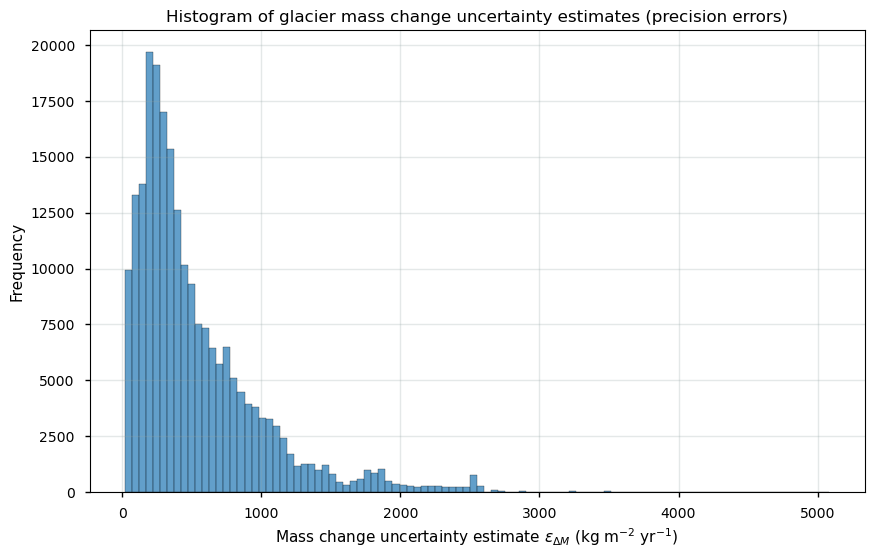

In [6]:
plt.figure(figsize=(10, 6))
error_kg_m2_yr = (1e6*ds['uncertainty_gt'].values.flatten()) / (ds['glacier_area_km2'].values.flatten())
plt.hist(error_kg_m2_yr, bins=100, edgecolor='black', alpha=0.7)
plt.title('Histogram of glacier mass change uncertainty estimates (precision errors)')
plt.xlabel('Mass change uncertainty estimate $\epsilon_{\Delta{M}}$ (kg m$^{-2}$ yr$^{-1}$)')
plt.ylabel('Frequency')
plt.grid(color='#95a5a6',linestyle='-',alpha=0.25)
plt.show()

Let us plot some statistics:

In [7]:
print(f"The overall arithmetic mean precision error over all pixels and all years is {np.nanmean(error_kg_m2_yr):.2f} kg m\u207B² yr\u207B\u00B9 with a maximum of {np.nanmax(error_kg_m2_yr):.2f} kg m\u207B² yr\u207B\u00B9.")

The overall arithmetic mean precision error over all pixels and all years is 530.69 kg m⁻² yr⁻¹ with a maximum of 5083.96 kg m⁻² yr⁻¹.


The overall arithmetic mean error over both space and time exhibits a moderate magnitude, and the majority of errors seem to be situated close to 200-500 kg m⁻² yr⁻¹. The threshold (i.e. the minimum requirement to be met to ensure that data are useful) for glacier mass change uncertainty (expressed in terms of 2$\sigma$) proposed by the GCOS is 500 kg m⁻² yr⁻¹, while the "breakthrough" value (i.e. the level at which specified uses within climate monitoring become possible) would be 200 kg m⁻² yr⁻¹ per grid point (GCOS, 2022).

Further investigation reveals that the errors do not exhibit a significant relationship with the glacier surface area nor with the absolute magnitude of the mass change in the corresponding pixels:

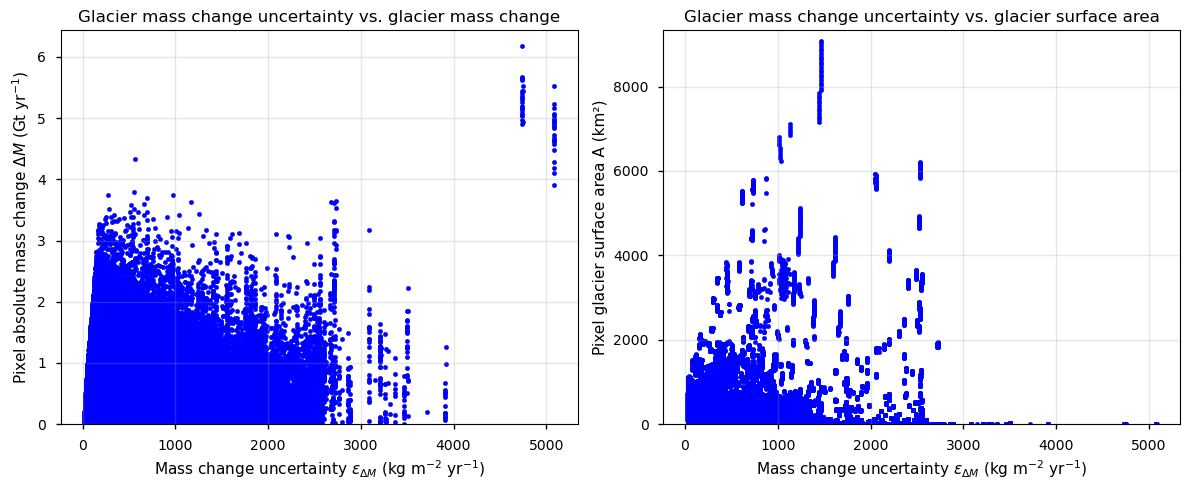

In [8]:
# Flatten the matrices to 1D arrays
x = error_kg_m2_yr
y1 = ds['glacier_mass_change_mwe'].values.flatten()
y2 = ds['glacier_area_km2'].values.flatten()

# Plot the data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# First scatter plot
ax1.scatter(x, abs(y1), color='b', s=10)
ax1.set_title('Glacier mass change uncertainty vs. glacier mass change')
ax1.set_xlabel('Mass change uncertainty $\epsilon_{\Delta{M}}$ (kg m$^{-2}$ yr$^{-1}$)')
ax1.set_ylabel('Pixel absolute mass change $\Delta{M}$ (Gt yr$^{-1}$)')
ax1.set_ylim(0, np.nanmax(abs(ds['glacier_mass_change_mwe']))+0.25)
ax1.grid(color='#95a5a6', linestyle='-', alpha=0.25)

# Second scatter plot
ax2.scatter(x, y2, color='b',s=10)
ax2.set_title('Glacier mass change uncertainty vs. glacier surface area')
ax2.set_xlabel('Mass change uncertainty $\epsilon_{\Delta{M}}$ (kg m$^{-2}$ yr$^{-1}$)')
ax2.set_ylabel('Pixel glacier surface area A (km²)')
ax2.set_ylim(0, np.nanmax(ds['glacier_area_km2'])+250)
ax2.grid(color='#95a5a6', linestyle='-', alpha=0.25)

# Display the plots
plt.tight_layout()
plt.show()

As an extra step, we can calculate the overall arithmetic mean glacier mass change precision error for each hydrological year to get a general idea of the overall magnitude of the errors. This is simply calculated as the spatial arithmetic mean of all pixels for each year $t$:

$\overline{\varepsilon_{\Delta{M}}}_{x,y}  
$
[kg m⁻² yr⁻¹]
$ = \dfrac{1}{n} \sum\limits^{{{x,y}}} (\varepsilon_{\Delta{M_{x,y}}})$ with $x,y$ the spatial domain size and $n$ is the total amount of latitude/longitude pixels (NaN pixels with no glaciers are excluded).

This results in the following:

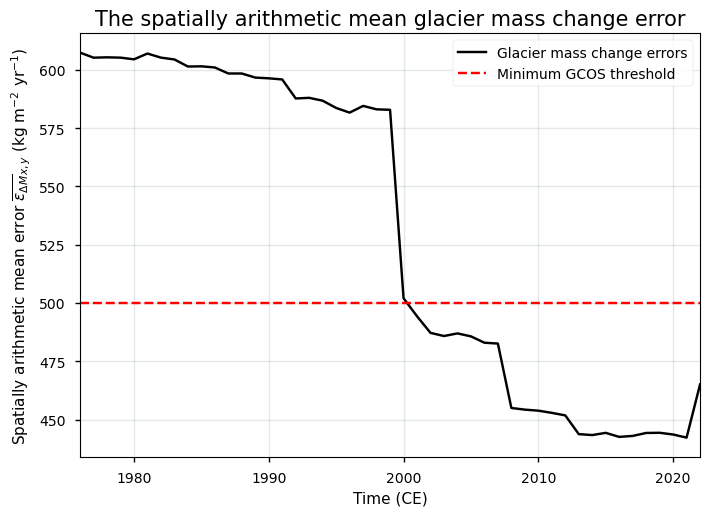

In [9]:
# Calculate area-weighted mean error for each year
mean_error_per_year = []

for t in ds['time']:
    errors = (1e6*ds['uncertainty_gt']/ds['glacier_area_km2']).sel(time=t).values
    
    # Flatten the arrays to perform the weighted mean calculation
    errors_flat = errors.flatten()
    
    # Calculate the area-weighted mean error
    mean_error = np.nanmean(errors_flat)
    mean_error_per_year.append(mean_error)

# Convert to a numpy array or xarray DataArray if needed
mean_error_per_year = np.array(mean_error_per_year)

fig, ax = plt.subplots()
ax.plot(ds['time'].values, mean_error_per_year,'k',label='Glacier mass change errors')
ax.axhline(y=500, color='r', linestyle='--',label='Minimum GCOS threshold')
ax.set_xlabel("Time (CE)")
ax.set_ylabel("Spatially arithmetic mean error $\overline{\epsilon_{\Delta{M}}}_{x,y}$ (kg m$^{-2}$ yr$^{-1}$)")
ax.set_title("The spatially arithmetic mean glacier mass change error", fontsize=15)
ax.grid(color='#95a5a6', linestyle='-', alpha=0.25)
ax.set_xlim(np.min(ds['time'].values), np.max(ds['time'].values))
plt.legend()
plt.show()

It can be noted that for the earlier years, the total (here only in terms of precision) error values (reported as 1.96$\sigma$) consistently, albeit slightly, exceed the threshold of 500 kg m⁻² yr⁻¹, which suggests relatively high uncertainty in the dataset. This potentially limits its applicability for certain purposes. During the more recent years, the error values remain below this threshold, but do not exhibit values particularly closer to or below the breakthrough value of 200 kg m⁻² yr⁻¹ per grid point. However, there is a decreasing trend in the overall mean error, indicating slightly more reliable data, with an improved suitability over time for climate monitoring and related applications. The dataset's error values thus meet the the threshold value proposed by GCOS only during the more recent years. This suggests that the dataset has relatively high uncertainty levels, potentially hindering certain applications and requiring further assessment or improvement to meet GCOS requirements.

Next, let us check the spatial distribution of the mean overall error over time per grid point, which is simply calculated as the temporal arithmetic mean over all years for each pixel $x,y$:

$\overline{\varepsilon_{\Delta{M_{t}}}} 
$
[kg m⁻² yr⁻¹]
$ = \dfrac{1}{n} \sum\limits_{i={1976}}^{{{1976+n-1}}} (\varepsilon_{\Delta{M_i}})$ with $n$ is the total amount of years in the time series.

This results in the following:

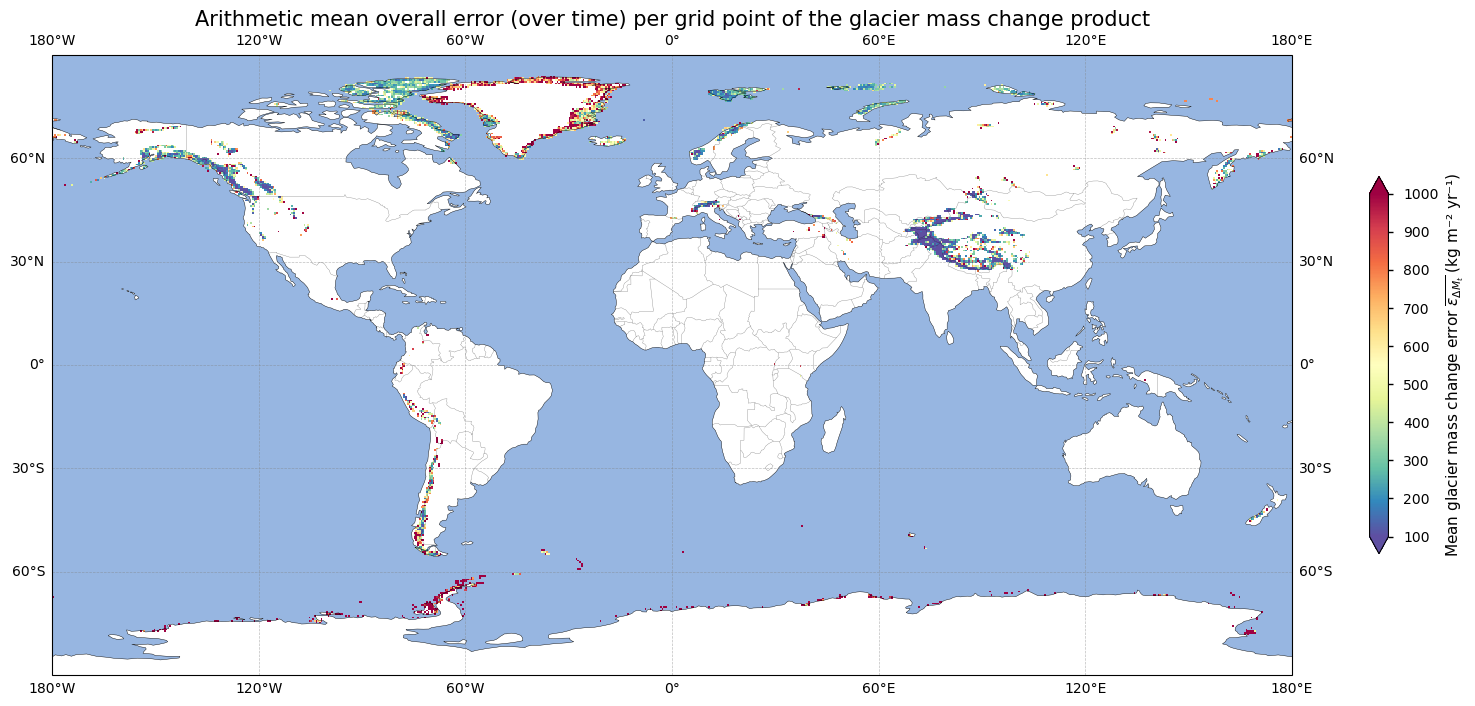

In [315]:
# Plot the gridded data
lon_grid, lat_grid = np.meshgrid(ds["longitude"].values, ds["latitude"].values)
fig=plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.add_feature(cfeature.LAND,color='w')
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.BORDERS,linewidth=0.25,alpha=0.5)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
         linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
error_spatial = (1e6*ds['uncertainty_gt']/ds['glacier_area_km2']).mean(("time"), keep_attrs=True)
im=ax.pcolormesh(ds["longitude"].values, ds["latitude"].values, error_spatial, transform=ccrs.PlateCarree(), cmap = mpl.cm.Spectral_r, vmin=100,vmax=1000)
fig.colorbar(im,ax=ax,extend='both',shrink=0.49,label='Mean glacier mass change error $\overline{\epsilon_{\Delta{M_{t}}}}$ (kg m⁻² yr⁻¹)')
plt.title('Arithmetic mean overall error (over time) per grid point of the glacier mass change product',fontsize=15)
plt.show()

The errors seem to be especially high in the peripheral glaciers and ice caps of the Greenland and Antarctic ice sheets, as well as in the southern Andean region. In these regions, the threshold value of 500 kg m⁻² yr⁻¹ is generally not reached. Let us make this plot a bit clearer by grouping these errors with respect to the threshold values proposed by the GCOS:

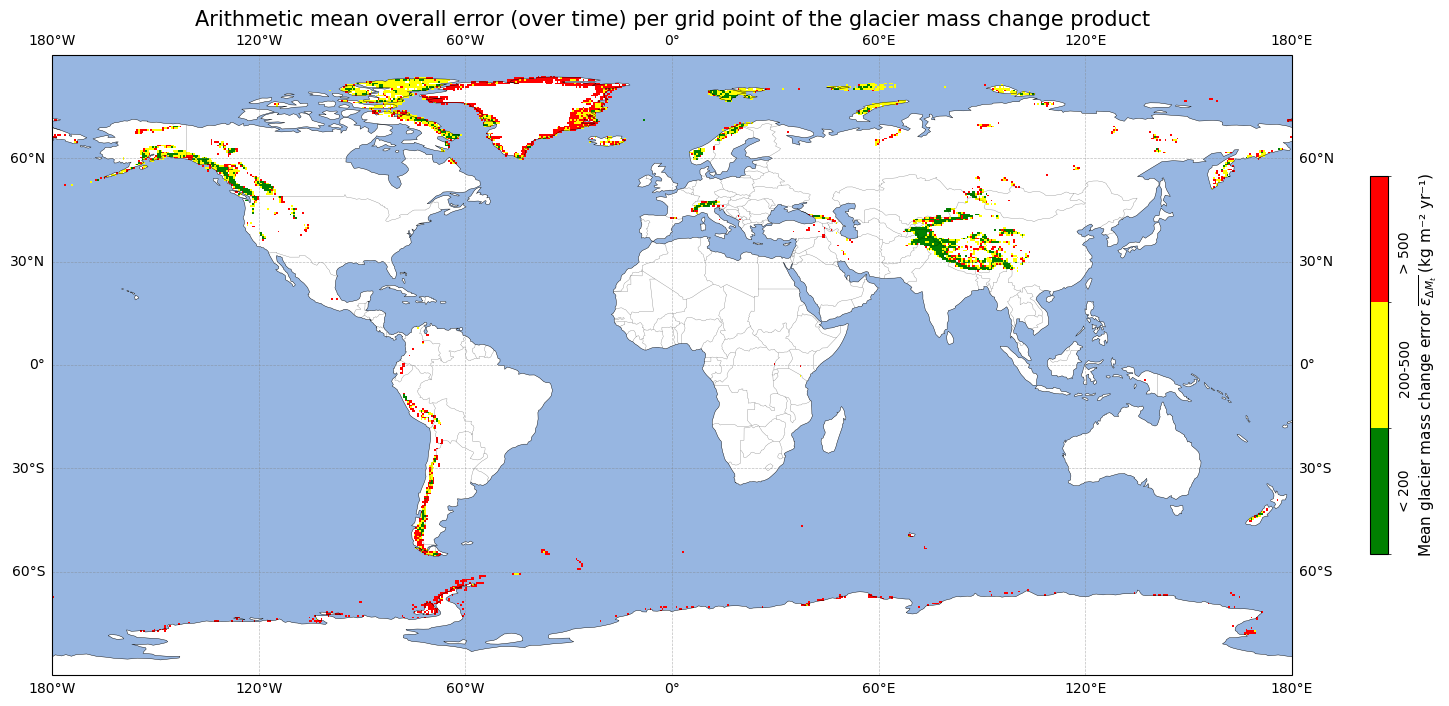

In [316]:
# Define the boundaries for the colorbar
bounds = [0, 200, 500, np.nanmax(error_spatial)]
cmap = mpl.colors.ListedColormap(['green','yellow', 'red'])
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
lon_grid, lat_grid = np.meshgrid(ds["longitude"].values, ds["latitude"].values)
fig = plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.add_feature(cfeature.LAND,color='w')
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.BORDERS, linewidth=0.25, alpha=0.5)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
error_spatial = (1e6 * ds['uncertainty_gt'] / ds['glacier_area_km2']).mean(("time"), keep_attrs=True)
# Plot the data
im = ax.pcolormesh(ds["longitude"].values, ds["latitude"].values, error_spatial, 
                   transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
cb = fig.colorbar(im, ax=ax, shrink=0.49, label='Mean glacier mass change error $\overline{\epsilon_{\Delta{M_{t}}}}$ (kg m⁻² yr⁻¹)', spacing="uniform")
cb.set_ticks([(0+250)/2, (200+600)/2, (650+np.nanmax(error_spatial))/2])  # Set the ticks at the midpoints of the ranges
cb.set_ticklabels(['< 200', '200-500', '> 500'])  # Set the tick labels
cb.ax.yaxis.set_tick_params(rotation=90)
cb.ax.yaxis.set_tick_params(length=0)
plt.title('Arithmetic mean overall error (over time) per grid point of the glacier mass change product', fontsize=15)
plt.show()

Green pixels indicate areas where the breakthrough value of (an uncertainty of 200 kg m⁻² yr⁻¹ or lower), as proposed by the GCOS, has been reached, whereas red grid points exhibit temporally arithmetic mean error values that exceed the threshold value (500 kg m⁻² yr⁻¹ or more) for the data to be useful. This confirms our statement from above: especially the Greenland and Antarctic peripheral glaciers and parts of the Andes exhibit error values that are clearly too high. Extra care from the user is required in these regions since the threshold value has not been reached. Other regions, such as High Mountain Asia and the majority of Alaskan and European glaciers, have precision error values that allow for a reliable and high-quality data analysis. Possible reasons for this pattern are the following:

- Sparse data coverage: glaciers in Greenland and Antarctica often have sparse glaciological samples compared to glaciers in other regions. Monitoring these regions can be challenging due to their remote and harsh environments, leading to fewer observational data points and less accurate measurements.
- Complex terrain and dynamics: glaciers in Greenland and Antarctica are typically characterized by complex terrain and dynamics. Satellite observations may furthermore have limitations in accurately capturing glacier surface elevation changes in these polar regions due to factors such as cloud cover and snow accumulation, leading to higher error values in mass change estimates. Also, processes such as firn densification and vertical bedrock motion complicate the volume (from elevation changes) to mass conversion. 
- Gridded data limitations: pixels in Antarctica and Greenland are highly glacierized. Due to the 0.5 degree spatial resolution, pixels get smaller in abolsute total surface area towards the poles and individual glaciers can therefore be larger than the grid surface in polar regions, resulting in grid cell artefacts. Separation of outlet glaciers from the main ice sheet body also remains difficult, resulting in relatively high uncertainties with respect to glacier area change rates. This can additionally introduce errors in the mass change estimation.

Let us quantify the percentage of data (over all pixels and all years) that do and do not reach the threshold values:

In [317]:
error_spatial = (1e6*ds['uncertainty_gt']/ds['glacier_area_km2'])
count_200 = (error_spatial < 200).sum().values
count_500 = (error_spatial > 500).sum().values
count_nonnan = np.sum(~np.isnan(error_spatial).values)
print(f"The percentage of data points with a glacier mass change error value less than 200 kg m⁻² yr⁻¹ is {(100*count_200/count_nonnan):.2f}%.")
print(f"The percentage of data points with a glacier mass change error value more than 500 kg m⁻² yr⁻¹ is {(100*count_500/count_nonnan):.2f}%.")

The percentage of data points with a glacier mass change error value less than 200 kg m⁻² yr⁻¹ is 21.79%.
The percentage of data points with a glacier mass change error value more than 500 kg m⁻² yr⁻¹ is 38.36%.


At last, let us check in which pixels the errors are decreasing or increasing over time. We therefore calculate the trends of the pixel-by-pixel error estimate over time and reclassify the data based on positive (increasing errors values over time in that pixel) and negative (decreasing error values over time in that pixel) trends.

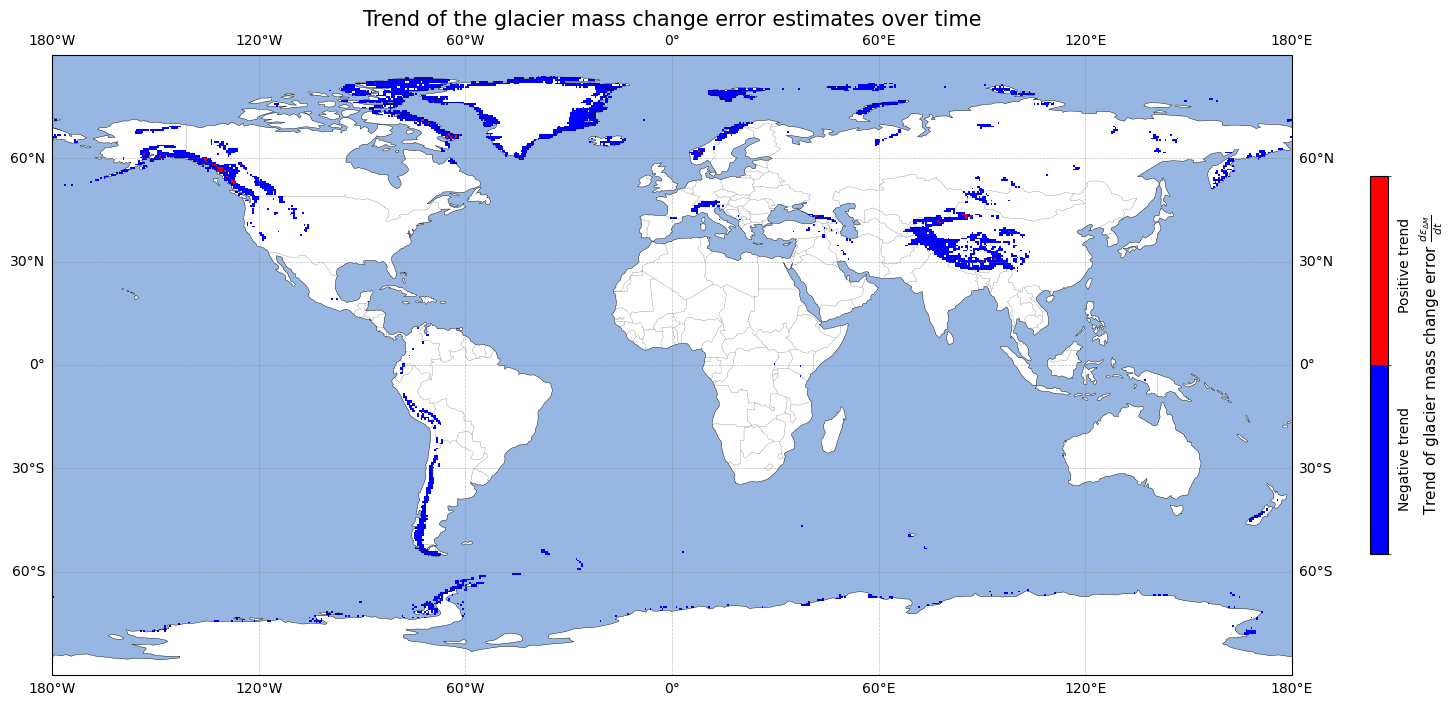

In [318]:
error_trend = (ds['uncertainty_gt']).polyfit("time", 1)["polyfit_coefficients"].sel(degree=1)

# Filter out NaN and Inf values
error_trend_filtered = np.ma.masked_invalid(error_trend)

# Define the boundaries for the colorbar
bounds = [-100, 0, 100]  # Define boundaries for negative and positive error trends
cmap = mcolors.ListedColormap(['blue', 'red'])  # Blue for negative, red for positive
norm = mcolors.BoundaryNorm(bounds, cmap.N)

lon_grid, lat_grid = np.meshgrid(ds["longitude"].values, ds["latitude"].values)
fig = plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.add_feature(cfeature.LAND,color='w')
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.BORDERS, linewidth=0.25, alpha=0.5)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# Plot the data
im = ax.pcolormesh(ds["longitude"].values, ds["latitude"].values, error_trend_filtered,
                   transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)

cb = fig.colorbar(im, ax=ax, shrink=0.49, label=r'Trend of glacier mass change error $\frac{d\epsilon_{\Delta M}}{dt}$', spacing="uniform")
cb.set_ticks([-25, 75])  # Set the ticks at the midpoints of the ranges
cb.set_ticklabels(['Negative trend', 'Positive trend'])  # Set the tick labels
cb.ax.yaxis.set_tick_params(rotation=90)
cb.ax.yaxis.set_tick_params(length=0)
plt.title('Trend of the glacier mass change error estimates over time', fontsize=15)
plt.show()


From the map above, it is obvious that errors are dominantly decreasing over time. A quantification of the errors and an analysis of the spatio-temporal distribution of these errors thus reveals interesting results. This info can be useful for the suitability of the data for various applications in cryospheric monitoring and related fields, such as quantifying the glacier-related contributions to global sea level change. Let us further assess the quality of the data by checking its spatio-temporal coverage.

### 🌍 Analysis of spatio-temporal coverage of glacier mass changes

To assess the spatio-temporal coverage of the data, we can make use of the `glacier_area_km2` variable within the dataset. Let us plot the global glacier area over time to get an idea of how this variable looks:

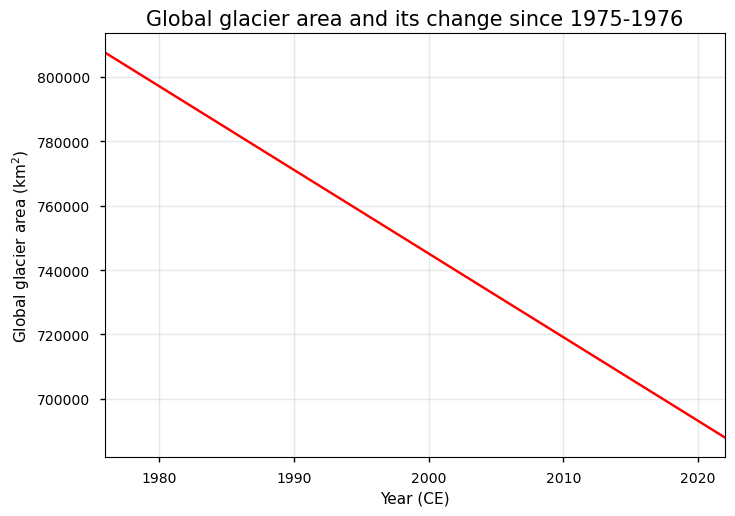

In [319]:
fig, ax = plt.subplots()
ax.plot(ds["time"],ds["Annual_area_km2"],'r')
ax.grid(color='#95a5a6',linestyle='-',alpha=0.25)
ax.set_xlim(np.min(ds["time"]),np.max(ds["time"]))
ax.set_xlabel("Year (CE)")
ax.set_ylabel("Global glacier area (km$^2$)")
ax.set_title("Global glacier area and its change since "+ period_start.replace("_","-"),fontsize=15);plt.show()

As can be seen from the plot above, the glacier area results from a linear decrease over time. It is hence not derived from in-situ and/or remote sensing data, but rather inserted into the data as a parameterization. For proper assessment, we can compare the value around 2000 CE to that of the 'Glaciers distribution data from the Randolph Glacier Inventory (RGI) for year 2000' dataset, which is 746088.28 km$^2$ from the vector (shape file) product in RGI v6.0 (RGI Consortium, 2017):

In [320]:
print(f"The total global glacier area in the glacier mass change dataset in 2000 CE is {ds['Annual_area_km2'].sel(time=2000).compute().item():.2f} km², which is {100*(ds['Annual_area_km2'].sel(time=2000).compute().item())/(746088.28):.2f}% of the area in the RGIv6.0 dataset.")

The total global glacier area in the glacier mass change dataset in 2000 CE is 745153.82 km², which is 99.87% of the area in the RGIv6.0 dataset.


The values of the regional linear glacier area change trend (for each RGI region) can also be easily computed:

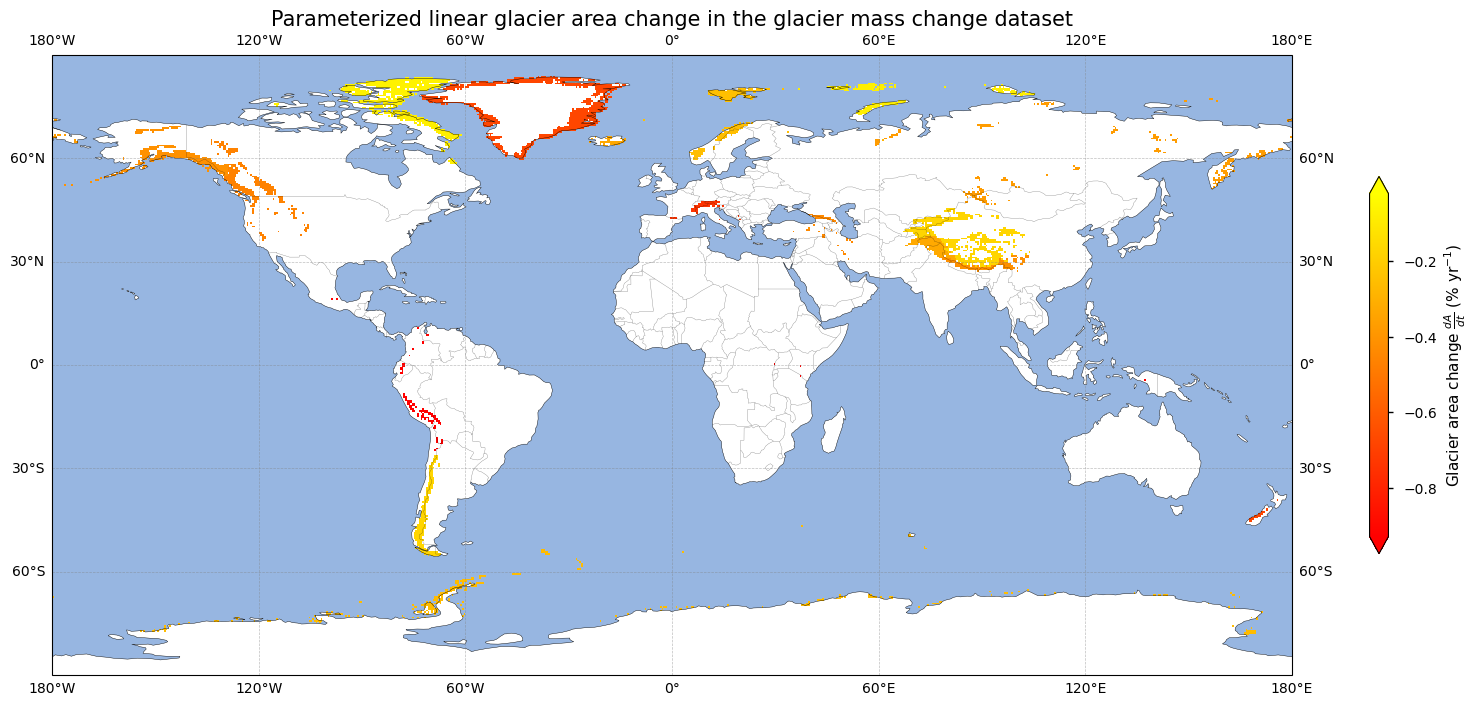

In [321]:
relative_area_change_grid = ds["glacier_area_km2"] / ds["glacier_area_km2"].isel(time=0) * 100
coeff_area = relative_area_change_grid.polyfit("time", 1)
slope_area = coeff_area["polyfit_coefficients"].sel(degree=1)
# Plot the gridded data
lon_grid, lat_grid = np.meshgrid(ds["longitude"].values, ds["latitude"].values)
fig=plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.add_feature(cfeature.LAND,color='w')
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.BORDERS,linewidth=0.25,alpha=0.5)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
         linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
im=ax.pcolormesh(ds["longitude"].values, ds["latitude"].values, slope_area, transform=ccrs.PlateCarree(), cmap = mpl.cm.autumn)
fig.colorbar(im,ax=ax,extend='both',shrink=0.49,label=r'Glacier area change $\frac{dA}{dt}$ (% yr$^{-1}$)')
plt.title('Parameterized linear glacier area change in the glacier mass change dataset',fontsize=15)
plt.show()

The global trend can then be compared to values in the literature to evaluate its accuracy:

In [322]:
slope, intercept, r_value, p_value_trend, std_err = linregress(ds["time"], ds['Annual_area_km2'])
relative_area_change = ds['Annual_area_km2'] / ds['Annual_area_km2'].isel(time=0) * 100
slope_rel, intercept_rel, r_value_rel, p_value_trend_rel, std_err_rel = linregress(ds['time'], relative_area_change)
print(f"The global linear trend of glacier area changes over time in the glacier mass change dataset between {period_start.replace('_', '-')} and {period_stop.replace('_', '-')} is {(slope):.2f} km² yr⁻¹ or {(slope_rel):.2f} % yr⁻¹.")

The global linear trend of glacier area changes over time in the glacier mass change dataset between 1975-1976 and 2021-2022 is -2600.53 km² yr⁻¹ or -0.32 % yr⁻¹.


Just like the absolute global glacier area around 2000 CE, also the number of the global linear trend above compares well with values from Zemp et al. (2019), who estimate the global glacier area change to be -0.34% yr⁻¹ between 1961-2016 when considered at the global scale. The dataset thus takes into account realistic glacier area changes to derive glacier mass changes. However, a linear decrease of the glacier areas may not be the best parameterization to consider in some regions. Many studies namely have reported recent accelerations of glacier retreat and shrinkage. This is, amongst others, the case in the Himalaya (Maurer et al., 2019), the Caucasus (Tielidze et al., 2022), western Canada (Bevington and Menounos, 2022), and the Altai Mountains (Chang et al., 2022). A linear trend may thus not be appropriate in these regions and may underestimate glacier area losses that are inserted into the glacier mass change calculation. 

To have an idea of the temporal coverage, we can plot the number of years that hold non-NaN mass change data for each pixel. If the pixel exhibits complete temporal coverage, the value should equal the number of years in the time dimension `time` of the dataset. In the map below, pixels where the time series of glacier mass change data has an amount of non-NaN values that equal the number of years in the time dimension of the data array are colored green, else they are colored red:

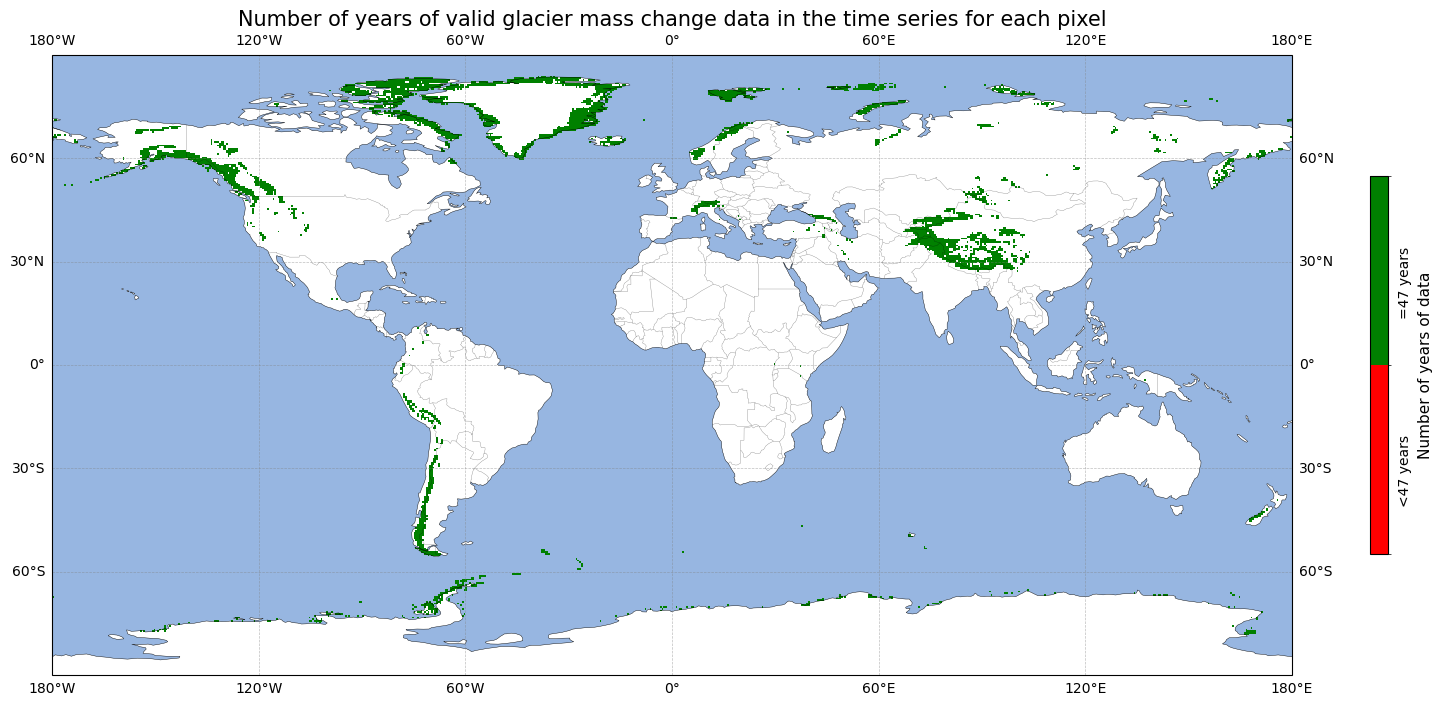

In [323]:
# Define the boundaries for the colorbar
bounds = [0, 0.5, 1]  # Green (0), Red (1)
cmap = mpl.colors.ListedColormap(['red', 'green'])
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
lon_grid, lat_grid = np.meshgrid(ds["longitude"].values, ds["latitude"].values)
fig = plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.add_feature(cfeature.LAND,color='w')
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.BORDERS, linewidth=0.25, alpha=0.5)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
non_nan_counts = ds["glacier_mass_change_gt"].count(dim="time").where(ds["glacier_mass_change_gt"].count(dim="time") != 0)
# Plot the data
im = ax.pcolormesh(ds["longitude"].values, ds["latitude"].values, non_nan_counts, 
                   transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
cb = fig.colorbar(im, ax=ax, shrink=0.49, label='Number of years of data', spacing="uniform")
cb.set_ticks([0.3, 0.8])  # Set the ticks at the midpoints of the ranges
cb.set_ticklabels([f'<{np.shape(ds["time"])[0]} years', f'={np.shape(ds["time"])[0]} years'])  # Set the tick labels
cb.ax.yaxis.set_tick_params(rotation=90)
cb.ax.yaxis.set_tick_params(length=0)
plt.title('Number of years of valid glacier mass change data in the time series for each pixel', fontsize=15)
plt.show()

Let us have this number quantified:

In [324]:
count_time = (non_nan_counts == np.shape(ds['time'])[0]).sum().values
count_nonnan = np.sum(~np.isnan(non_nan_counts).values)
print(f"The number of pixels that have a time series of valid glacier mass change data of {np.shape(ds['time'])[0]} years, which is the total number of years in the dataset, is {(100*count_time/count_nonnan):.2f}%.")

The number of pixels that have a time series of valid glacier mass change data of 47 years, which is the total number of years in the dataset, is 100.00%.


In other words, from the above analysis it becomes clear that the dataset exhibits consistently complete temporal and spatial coverage, which allows for reliable quantifications of global glacier mass change values. The temporal resolution of 1 year is also consistent with the minimal threshold value proposed by GCOS (2022), although the ultimate goal would be to have glacier mass changes at a monthly time scale. Although the numbers above suggest a quality-rich dataset in terms of spatio-temporal coverage, some potential limitations include:
- Although a threshold spatial resolution is not given by GCOS (2022), it is worth noting that data can not be consulted at the individual glacier-scale, instead the data are presented at a 0.5 degree global grid.
- It is impossible to determine the number of glaciers in a particular year for which mass or elevation changes are available. It is hence not possible to determine which regions are under/oversampled in space or time, or to quantify how many glacier mass change data are derived from the glaciological or geodetic methods respectively.
- The hydrological year varies from region to region, meaning that annual values from a pixel or region in the northern hemisphere are temporally not fully consistent with annual values from a pixel or region in the southern hemisphere.
- Data were furthermore measured and generated by different institutes/research groups and from different methods (i.e. the in-situ glaciological and satellite-based geodetic methods). As such, they were (with a high degree of certainty) not compiled in a fully consistent way for the entire dataset.

Now, let us plot the global annual mass change data over time and propagate its error throughout the time series.

### 📉 Quantifying global (cumulative) glacier mass changes since 1975-1976

In the following section, we plot the global annual (and cumulative) glacier mass change over time. For the annual values, we therefore sum the gridded mass change product over the entire spatial domain for each individual year to get spatially summed values in Gt yr⁻¹, and calculate the glacier area-weighted mean to get a mass balance value in m w.e. yr⁻¹:

$\Delta M 
$
[Gt yr⁻¹]
$ = \sum\limits^{x,y}\Delta {M_{x,y}}$ 

where $\Delta {M_{x,y}}$ is the glacier mass change (from `glacier_mass_change_gt`, in Gt yr⁻¹) at pixel $x,y$ during a certain year, and

$\overline{\Delta B} 
$
[m w.e. yr⁻¹]
$ = \textstyle\dfrac{1}{\sum\limits^{x,y} A_{x,y}} {\sum\limits^{x,y} (A_{x,y} \cdot \Delta {B_{x,y}})}$ 

where $\Delta {B_{x,y}}$ is the glacier mass balance (from `glacier_mass_change_mwe`, in m w.e. yr⁻¹) and $A_{x,y}$ the glacier area [km$^2$] at pixel $x,y$ (from `glacier_area_km2`) during a certain year.

This results in the following plot: 

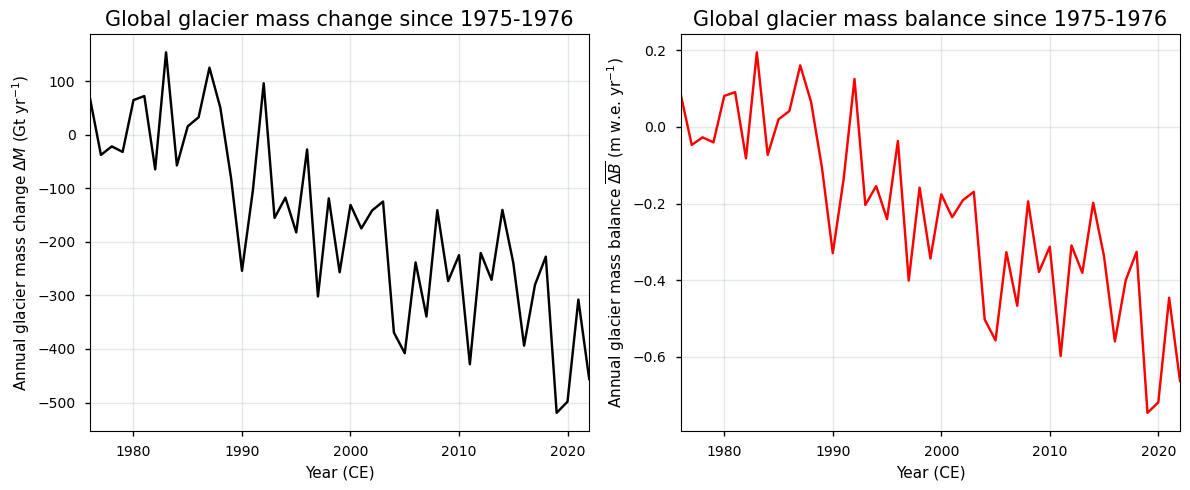

In [325]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(ds["time"],ds["Annual_gt"].values,color='k')
ax1.grid(color='#95a5a6',linestyle='-',alpha=0.25)
ax1.set_xlim(np.min(ds["time"]),np.max(ds["time"]))
ax1.set_xlabel("Year (CE)")
ax1.set_ylabel(r"Annual glacier mass change $\Delta M$ (Gt yr$^{-1}$)")
ax1.set_title("Global glacier mass change since "+ period_start.replace("_","-"),fontsize=15);
ax2.plot(ds["time"],ds["Annual_mwe"].values,color='r')
ax2.grid(color='#95a5a6',linestyle='-',alpha=0.25)
ax2.set_xlim(np.min(ds["time"]),np.max(ds["time"]))
ax2.set_xlabel("Year (CE)")
ax2.set_ylabel("Annual glacier mass balance $\overline{\Delta B}$ (m w.e. yr$^{-1}$)")
ax2.set_title("Global glacier mass balance since "+ period_start.replace("_","-"),fontsize=15);
plt.tight_layout()
plt.show()

The mass changes in the left plot above are expressed in Gt yr$^{-1}$ (Gigatonnes per year). Since Gt is a unit of mass, the mass of 1 Gt of ice is exactly the same as the mass of 1 Gt of water. The value can, however, also be translated into a volume. For example, 1 Gt of water (density 1000 kg/m³) is exactly 1 km³ water, while 1 Gt of ice (density 917 kg/m³) becomes 1.091 km³ of ice in volume. 

The corresponding annual global mass change uncertainty is calculated by assuming that errors are spatially uncorrelated and hence independent. For error propagation, we divide the uncertainty estimates by 1.96 since errors values are reported as 1.96 times the standard deviation:

$
\sigma_{\Delta{M}} 
$
[Gt yr⁻¹]
$= \sqrt{\sum\limits^{x,y}({\sigma_{ \Delta{M_{x,y}}}})^2}
$

where $\sigma_{ \Delta{M_{x,y}}}$ is the mass change standard deviation (from `uncertainty_gt` divided by 1.96, in Gt yr⁻¹) at pixel $x,y$ during a certain year, and

$
\sigma_{\overline{\Delta{B}}} 
$
[m w.e. yr⁻¹]
$= \sqrt{\sum\limits^{x,y} \left( \dfrac{A_{x,y}}{\sum\limits^{x,y} A_{x,y}} \cdot {\sigma_{\overline{\Delta{B}_{x,y}}}} \right)^2 }
$

where $\sigma_{\overline{ \Delta{B_{x,y}}}}$ is the mass balance standard deviation (from `uncertainty_mwe` divided by 1.96, in m w.e. yr⁻¹) at pixel $x,y$ during a certain year and $A_{x,y}$ the glacier area [km$^2$] (from `glacier_area_km2`).

Plotting these data reveals the following:

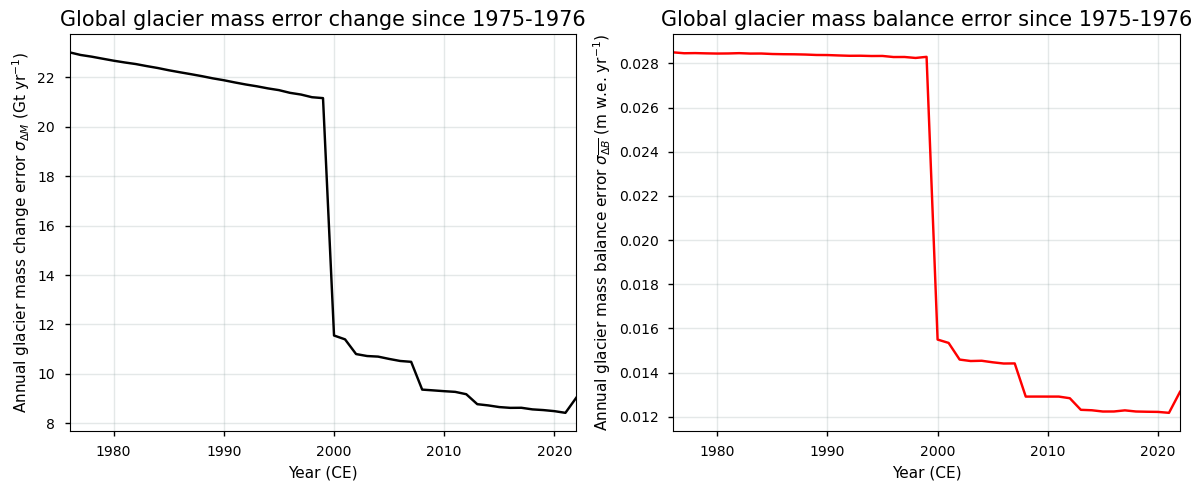

In [336]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(ds["time"],ds["Annual_error_gt"].values,color='k')
ax1.grid(color='#95a5a6',linestyle='-',alpha=0.25)
ax1.set_xlim(np.min(ds["time"]),np.max(ds["time"]))
ax1.set_xlabel("Year (CE)")
ax1.set_ylabel(r"Annual glacier mass change error $\sigma_{\Delta M}$ (Gt yr$^{-1}$)")
ax1.set_title("Global glacier mass error change since "+ period_start.replace("_","-"),fontsize=15);
ax2.plot(ds["time"],ds["Annual_error_mwe"].values,color='r')
ax2.grid(color='#95a5a6',linestyle='-',alpha=0.25)
ax2.set_xlim(np.min(ds["time"]),np.max(ds["time"]))
ax2.set_xlabel("Year (CE)")
ax2.set_ylabel(r"Annual glacier mass balance error $\sigma_{\overline{\Delta B}}$ (m w.e. yr$^{-1}$)")
ax2.set_title("Global glacier mass balance error since "+ period_start.replace("_","-"),fontsize=15);
plt.tight_layout()
plt.show()

It can be seen from the plot that the global glacier mass change uncertainty has been decreasing over time, with a sudden drop around 2000 CE. Note that due to potential spatial autocorrelation, the error in the above estimate (assuming independent errors) might be underestimated.

The data can also be plotted in a cumulative way:

$
{M} 
$
[Gt]
$
= \sum\limits_{i={1976}}^{{{1976+n-1}}} (\Delta M_i)
$
, or

$
{\overline{B}} 
$
[m w.e.]
$
= \sum\limits_{i={1976}}^{{{1976+n-1}}} (\overline{\Delta B_i})
$

with the global annual glacier mass change (in Gt yr⁻¹) or balance (m w.e. yr⁻¹) at a certain year $i$ (as calculated above) and $n$ the number of years in the time series.

The corresponding uncertainty is again calculated by assuming uncorrelated errors:

$
\sigma_{{M}}
$
[Gt]
$
= \sqrt{\sum\limits_{i={1976}}^{{1976+n-1}} (\sigma_{\Delta{M_i}})^2}
$
, or

$
\sigma_{{\overline{B}}}
$
[m w.e.] = 
$
\sqrt{\sum\limits_{i={1976}}^{{1976+n-1}} (\sigma_{\overline{\Delta{B_i}}})^2}
$

with the global annual mass change (in Gt yr⁻¹) or balance (m w.e. yr⁻¹) uncertainty at a certain year $i$ (as calculated above) and $n$ the number of years in the time series.

The corresponding plot looks as follows (note that in the cumulative time series, we multiply the propagated errors again by 1.96 to be consistent with the original errors presented in the dataset):

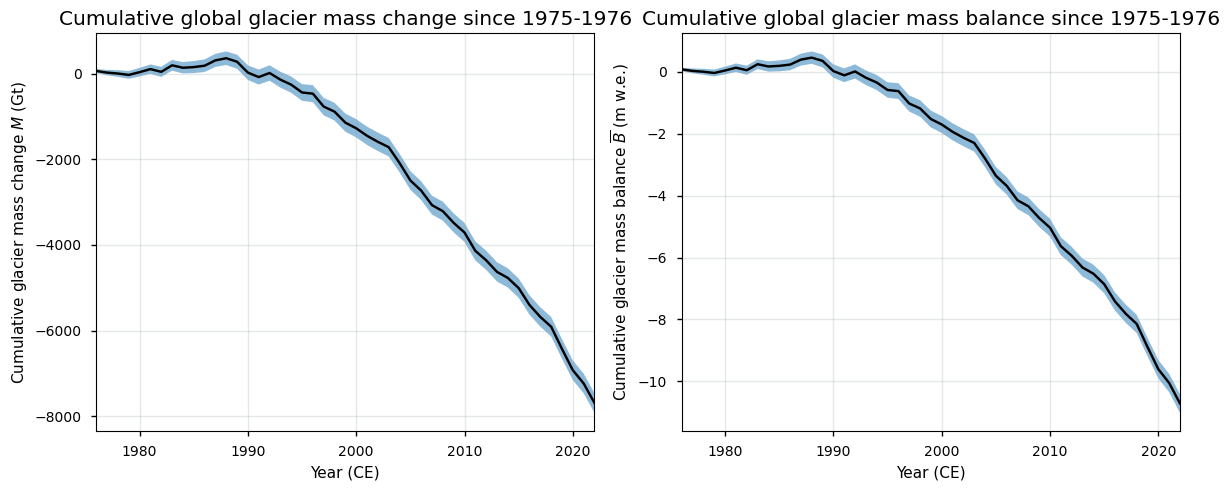

In [338]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
line1 = ds["Cumulative_gt"]
error1 = ds["Cumulative_error_gt"]
ax1.fill_between(line1["time"], line1 - error1*1.96, line1 + error1*1.96, alpha=0.5)
line1.plot(ax=ax1, color="k")
ax1.grid(color='#95a5a6',linestyle='-',alpha=0.25)
ax1.set_xlim(np.min(ds["time"]),np.max(ds["time"]))
ax1.set_xlabel("Year (CE)")
ax1.set_ylabel("Cumulative glacier mass change $M$ (Gt)")
ax1.set_title("Cumulative global glacier mass change since "+ period_start.replace("_","-"),fontsize=14.5);
line2 = ds["Cumulative_mwe"]
error2 = ds["Cumulative_error_mwe"]
ax2.fill_between(line2["time"], line2 - error2*1.96, line2 + error2*1.96, alpha=0.5)
line2.plot(ax=ax2, color="k")
ax2.grid(color='#95a5a6',linestyle='-',alpha=0.25)
ax2.set_xlim(np.min(ds["time"]),np.max(ds["time"]))
ax2.set_xlabel("Year (CE)")
ax2.set_ylabel("Cumulative glacier mass balance $\overline{B}$ (m w.e.)")
ax2.set_title("Cumulative global glacier mass balance since "+ period_start.replace("_","-"),fontsize=14.5);
plt.tight_layout()
plt.show()

From the image above, it can be seen that glaciers clearly have been losing mass during the observational period, especially since the 1990s. The final estimate of the glaciers mass change at the end of the time series is:

In [339]:
print(f"The total global cumulative glacier mass change between {period_start.replace('_', '-')} and {period_stop.replace('_', '-')} is {line2.values[-1]:.2f} ± {error2.values[-1]*1.96:.2f} m w.e. or {line1.values[-1]:.2f} ± {error1.values[-1]*1.96:.2f} Gt.")

The total global cumulative glacier mass change between 1975-1976 and 2021-2022 is -10.72 ± 0.30 m w.e. or -7691.70 ± 230.53 Gt.


Note that due to potential spatial/temporal error correlation in the time series, the error in the above estimate (assuming independent errors) might be underestimated. Now, let us use the glacier mass change data to quantify the link between glacier melt and glacier-related contributions to global sea level rise in the context of Earth System modeling and climate change monitoring.

### 🌊 Quantification of glacier-related contributions to global sea level change

Changes in mean global sea level can be caused by various processes. Mass changes of glaciers are only a part of the total contribution:

$\Delta SL = \Delta SL_{steric} + \Delta SL_{VLM} + \Delta SL_{glac} + \Delta SL_{IS} + \Delta SL_{LWS} + \Delta SL_{other}$

where $\Delta SL_{steric}$ is the term related to changes in density caused by variations in temperature (thermosteric) and salinity (halosteric), $\Delta SL_{VLM}$ is the term related to changes due to vertical land motion, $\Delta SL_{glac}$ and $\Delta SL_{IS}$ are related to mass addition/removal by glaciers, ice caps, and ice sheets, $\Delta SL_{LWS}$ is a land water storage term that includes processes such as deep groundwater mining and dam building, and lastly, $\Delta SL_{other}$ quantifies the other remaining and less significant processes, such as the presence and melting of a seasonal snow cover.

With all the information above, we can calculate the contribution of glacier mass changes to global sea level change during the last several decades. We therefore make use of the following formula (e.g. Farinotti et al., 2019):

$
\Delta SL_{glac} = h_{SLE} 
$
[mm]
$
= 1 \cdot 10^6 \cdot \sum\limits_{i=1976}^{1976+n-1} \left(\dfrac{V_{w,i}}{A_s} \cdot \dfrac{\rho_w}{\rho_s}\right)
$

where 
$
{V_{w,i}} = \sum\limits^{x,y}\left(\dfrac{\Delta {B_{x,y}}}{1 \cdot 10^3} \cdot A_{x,y}\right)
$.

Here, $\Delta {B_{x,y}}$ is the glacier mass balance (in m w.e. yr⁻¹) at pixel $x,y$ during a certain year $i$ from `ds["glacier_mass_change_mwe"]`, and $A_{x,y}$ the glacier area [km$^2$] from `ds["glacier_area_km2"]`, so that the annual volume change $V_w$ has units of km$^3$ yr$^{-1}$ of water. Furthermore, ${A_{s}}$ is the ocean surface area [km²], $n$ the total number of years in the time series and $\rho$ the respective densities of water $w$ and the sea $s$ [kg m⁻³]. Note that this formulation assumes that all glacier mass or volume losses directly contribute to sea level changes. Also note that by multiplying the sea level contribution by $\frac{\rho_w}{\rho_s}$, we calculate sea level contributions in ocean water column equivalent.

The corresponding uncertainty is given by:

$
\sigma_{h_{SLE}} 
$
[mm] = 
$
1 \cdot 10^6 \cdot \left(\dfrac{1}{A_s} \dfrac{{\rho_{w}}}{\rho_{s}}\right) \cdot \sqrt{ \sum\limits_{i={1976}}^{{{1976+n-1}}} (\sigma_{{V_{w,i}}})^2}
$

where $\sigma_{\Delta{V_w}}$ is the corresponding volume change uncertainty [km$^{3}$ yr$^{-1}$] calculated from the mass balance uncertainty and the glacier area, again taking into account that uncertainties at the pixel level are given as 1.96 times the standard deviation.

This results in:

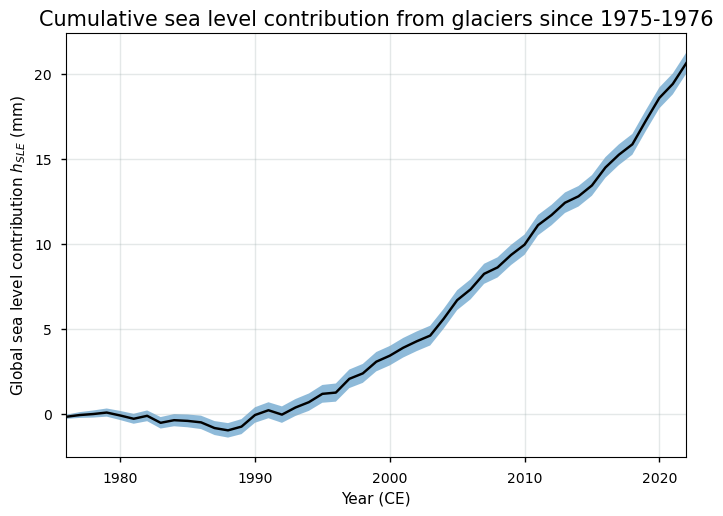

In [329]:
# Define some variables
A_ocean = 3.625E8  # Ocean surface area
p_ice = 917        # Ice density
p_sea = 1028       # Ocean water density
p_water = 1000     # Fresh water density
# Calculate global sea level contribution
vol_ice = (((ds["glacier_mass_change_mwe"]/1000) * ds["glacier_area_km2"]).sum(dim=("latitude", "longitude"), keep_attrs=True)).cumsum("time")
hsle = -1E6*(vol_ice/(A_ocean))*(p_water/p_sea)             
vol_ice_error = (((ds["glacier_area_km2"] * ((ds['uncertainty_mwe']/1000)/1.96)) ** 2).sum(dim=['latitude', 'longitude'],keep_attrs=True) ** 0.5)
cumulative_vol_ice_error = ((vol_ice_error**2).cumsum("time")) ** 0.5
hsle_error = 1E6*(((p_water/p_sea)/(A_ocean))**2*(cumulative_vol_ice_error)**2) ** 0.5
# Plot the data
fig, ax = plt.subplots()
line = hsle
error = hsle_error
ax.fill_between(line["time"], line - error*1.96, line + error*1.96, alpha=0.5)
line.plot(ax=ax, color="k")
ax.grid(color='#95a5a6',linestyle='-',alpha=0.25)
ax.set_xlim(np.min(ds["time"]),np.max(ds["time"]))
ax.set_xlabel("Year (CE)")
ax.set_ylabel("Global sea level contribution $h_{SLE}$ (mm)")
ax.set_title("Cumulative sea level contribution from glaciers since "+ period_start.replace("_","-"),fontsize=15);
plt.show()

Let us quantify the total glacier-related contribution to global sea level change since the beginning of the dataset:

In [330]:
print(f"The total contribution of glacier mass changes to global sea level change between {period_start.replace('_', '-')} and {period_stop.replace('_', '-')} is {line.values[-1]:.2f} ± {error.values[-1]*1.96:.2f} mm.")

The total contribution of glacier mass changes to global sea level change between 1975-1976 and 2021-2022 is 20.64 ± 0.62 mm.


However, if we want to know the effective contribution of glacier-related mass changes to global sea level changes, we have to take into account several additional processes. That is, mass changes of ice below buoyancy for ice grounded below sea level, and also mass changes of floating ice (i.e. ice situated beyond the grounding line and is hence not "grounded", i.e. not resting on bedrock) have to be excluded form the calculations (due to the Archimedes' principle). In other words, only ice above buoyancy (i.e. above freeboard) contributes to global sea level changes, or put differently, ice below floatation does not contribute directly to sea level rise because it is already displacing its weight in water due to its buoyancy. Moreover, pixels with land-locked glaciers (i.e. pixels with glaciers that do not have a direct connectivity to the oceans), nor pixels where meltwater would be stored in (future) terrestrial lakes (and hence also does not reach the ocean), have to be excluded. This results in an effective contribution to sea level change (e.g. Farinotti et al., 2019):

$
h_{SLE,eff} 
$
[mm] = 
$
1 \cdot 10^6 \cdot \sum\limits_{i={1976}}^{{{1976+n-1}}} \left(\dfrac{(V_{w,i} - V_{excl,i})}{A_{s}}\dfrac{{\rho_{w}}}{\rho_{s}}\right)
$

with 
$
V_{excl}
$
the excluded volume and $n$ the number of years. Accounting for these factors, however, requires additional data that are not provided on the CDS (such as the ice thickness and bedrock elevation data, for example, to determine the ice volume below buoyancy for ice grounded below sea level). Additional processes furthermore complicate the sea level contribution calculation (e.g. bedrock elevation changes due to processes such as glacial isostatic adjustment, and/or the density difference between fresh water from melted ice and the more saline ocean water (Goelzer et al., 2020)).

The glacier mass change product that is on the CDS is thus found to be highly applicable to monitor and derive global (cumulative) mass changes over time and to, for example, assess the corresponding impact on global sea level changes. Because the glacier mass change data are expressed as mass changes in Gt yr$^{-1}$ or mass balances in m w.e. yr$^{-1}$, they can be directly converted to global sea level change (if it is assumed that all mass changes directly contribute to sea level changes, which is not everywhere the case). The analysis above points out that the dataset is reliable in terms of its precision when compared to the minimum GCOS requirements (especially during the more recent years) and its consistency with respect to spatial (i.e. global) and temporal (i.e. since 1975-76 without data gaps) coverage. The data can thus be considered mature with respect to these conditions, confirming the suitability of the glacier mass change dataset to quantify the link between glacier melt and glacier-related contributions to global sea level rise in the context of Earth System modeling and climate change monitoring. Extra care of the user is however required in certain regions (e.g. the peripheral glaciers of Antarctica and Greenland, where relatively high uncertainty values persist). Moreover, in order to calculate effective global sea level changes (i.e. to exclude ice mass losses of ice below buoyancy from ice grounded below sea level, landlocked glaciers and mass changes of floating glacier ice), additional external information is required for the user. Furthermore, when using the glacier mass change dataset that is available on the CDS, users should be aware of the additional typical problems with the dataset (e.g. the absence of information with respect to the number of sampled glaciers per pixel and year to derive the corresponding glacier mass change value), as discussed previously in this notebook.

## ℹ️ If you want to know more

### Key resources

- "Glacier mass change gridded data from 1976 to present derived from the Fluctuations of Glaciers Database" on the CDS
- [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control` prepared by [BOpen](https://www.bopen.eu).

### References

- Berthier, E., Floriciou, D., Gardner, A.S., Gourmelen, N., Jakob, L., Paul, F., Treichler, D., Wouters, B., Belart, J.M.C., Dehecq, A., Dussaillant, I., Hugonnet, R., Kääb, A., Krieger, L., Pálsson, F., and Zemp, M. (2023). Measuring glacier mass changes from space—a review. Rep. Prog. Phys. 86, 036801. doi:10.1088/1361-6633/acaf8e.

- Bevington, A. R., and Menounos, B. (2022). Accelerated change in the glaciated environments of western Canada revealed through trend analysis of optical satellite imagery. Remote Sensing of Environment, 270, 112862. doi: 10.1016/j.rse.2021.112862.

- Chang, J., Wang, N., Li, Z., and Yang, D. (2022). Accelerated Shrinkage of Glaciers in the Altai Mountains from 2000 to 2020. Front. Earth Sci. 2022, 10, 919051. doi: 10.3389/feart.2022.919051.

- Farinotti, D., Huss, M., Fürst, J. J., Landmann, J., Machguth, H., Maussion, F., and Pandit, A. (2019). A consensus estimate for the ice thickness distribution of all glaciers on Earth. Nature Geoscience, 12(3), 168-173. doi: 10.1038/s41561-019-0300-3.

- GCOS (Global Climate Observing System) (2022). The 2022 GCOS ECVs Requirements (GCOS-245). World Meteorological Organization: Geneva, Switzerland. doi: https://library.wmo.int/idurl/4/58111.

- Goelzer, H., Coulon, V., Pattyn, F., de Boer, B., and van de Wal, R. (2020). Brief communication: On calculating the sea-level contribution in marine ice-sheet models, The Cryosphere, 14, 833–840, doi: 10.5194/tc-14-833-2020.

- Maurer, J. M., Schaefer, J. M., Rupper, S., and Corley, A. (2019). Acceleration of ice loss across the Himalayas over the past 40 years. Sci Adv., 2019 Jun 19, 5(6), eaav7266. doi: 10.1126/sciadv.aav7266.

- RGI Consortium (2017). Randolph Glacier Inventory – A Dataset of Global Glacier Outlines: Version 6.0: Technical Report, Global Land Ice Measurements from Space, Colorado, USA. Digital Media. doi: 10.7265/N5-RGI-60.

- Tielidze, L. G., Nosenko, G. A., Khromova, T. E., and Paul, F. (2022). Strong acceleration of glacier area loss in the Greater Caucasus between 2000 and 2020, The Cryosphere, 16, 489–504. doi: 10.5194/tc-16-489-2022.

- WGMS (2022). Fluctuations of Glaciers Database. doi: 10.5904/wgms-fog-2022-09.

- Zemp, M., Huss, M., Thibert, E., Eckert, N., McNabb, R., Huber, J., Barandun, M., Machguth, H., Nussbaumer, S. U., Gärtner-Roer, I., Thomson, L., Paul, F., Maussion, F., Kutuzov, S., and Cogley, J. G. (2019). Global glacier mass changes and their contributions to sea-level rise from 1961 to 2016. Nature, 568, 382–386. doi: 10.1038/s41586-019-1071-0.